# Chemical Kinetics

> Find Steady State and time dependent concentrations of species

In [ ]:
#| default_exp kinetics

In [ ]:
#| export
#| echo: false
import numpy as np

In [ ]:
#| hide
import matplotlib
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [ ]:
#| export
def steady_state_calc(kf1:float, # rate constant for D->I
                      kr1:float, # rate constant for I->D
                      kf2:float, # rate constant for I->N
                      kr2:float  # rate constant for N->I
                      ):
    """
    Calculate the steady state equilibrium of reaction D<->I<->N, given the rate of the forwards and backwards processes at each step
    """
    mat = np.array([[-kf1,kr1,0],[0,kf2,-kr2],[1,1,1]])
    vec = np.array([0,0,1])
    mat_inv = np.linalg.inv(mat)
    out = np.matmul(mat_inv, vec)
    return out

For instance, for varying concentrations of urea:

Consider the reaction

$$D  \xrightleftharpoons[k_{u}^{R15}]{k_{f}^{R15}}  I  \xrightleftharpoons[k_{u}^{R16}]{k_{f}^{R16}} N$$

In the steady state, the rate of change of all components it null and so

$$k_{u}^{R15}[I]-k_{f}^{R15}[D]=0$$
$$k_{f}^{R16}[I]-k_{u}^{R16}[N]=0$$

and with an additional restriction that the total number of substances is constant: wlg let that be 1:

$$[D]+[I]+[N]=1$$

As such this can be represented as a matrix:

$$\begin{pmatrix}-k_{f}^{R15}&k_{u}^{R15}&0\\ 0 & k_{f}^{R16} & -k_{u}^{R16}\\ 1&1&1\end{pmatrix}\begin{pmatrix} [D] \\ [I] \\ [N] \end{pmatrix} = \begin{pmatrix} 0 \\ 0 \\ 1 \end{pmatrix}$$

And thus

$$\begin{pmatrix} [D] \\ [I] \\ [N] \end{pmatrix} = \frac{1}{k_{f}^{R15}k_{f}^{R16}+k_{f}^{R15}k_{u}^{R16}+k_{u}^{R15}k_{u}^{R16}}\begin{pmatrix}-k_{f}^{R16}-k_{u}^{R16}&k_{u}^{R15}&k_{u}^{R15}k_{u}^{R16}\\ k_{u}^{R16} & k_{f}^{R15} & k_{f}^{R15}k_{u}^{R16}\\ k_{f}^{R16}&-k_{f}^{R15}-k_{u}^{R15}&k_{f}^{R15}k_{f}^{R16}\end{pmatrix}\begin{pmatrix} 0 \\ 0 \\ 1 \end{pmatrix}$$

In [ ]:
kf1 = 26000
kr1 = 0.06
kf2 = 730
kr2 = 0.00075
urea_conc = np.linspace(0, 8, num=10000)
ss_conc = np.array([steady_state_calc(kf1*np.exp(-1.68*conc), kr1*np.exp(0.95*conc), kf2*np.exp(-1.72*conc), kr2*np.exp(1.20*conc)) for conc in urea_conc])


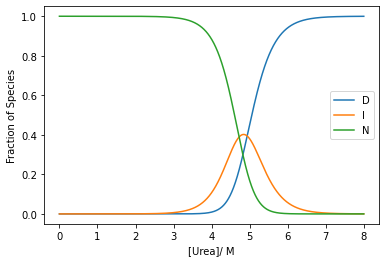

In [ ]:
plt.plot(urea_conc,ss_conc[:, 0],label='D')
plt.plot(urea_conc,ss_conc[:, 1],label='I')
plt.plot(urea_conc,ss_conc[:, 2],label='N')
plt.xlabel('[Urea]/ M')
plt.ylabel('Fraction of Species')
plt.legend()
plt.show()

In [ ]:
#| hide
# def _deriv(t, concs, k1, k2, k3, k4, k5):
#     """
#     Returns the time derivatives of concs = A, B, X, Y, Z, P, Q
#     """
#     A, B, X, Y, Z, P, Q = concs
#     Adot = -A*Y*k1
#     Bdot = -B*X*k3
#     Xdot = A*Y*k1 - X*Y*k2 + B*X*k3 - 2*X*X*k4
#     Ydot = -A*Y*k1 - X*Y*k2 + Z*k5
#     Zdot = B*X*k3 - Z*k5
#     Pdot = A*Y*k1 + X*Y*k2
#     Qdot = X*X*k4
#     return Adot, Bdot, Xdot, Ydot, Zdot, Pdot, Qdot

In [ ]:
#| export
def _deriv(t, concs, k1, k2, k3, k4, k5):
    """
    Returns the time derivatives of concs = A, B, X, Y, Z, P, Q
    """
    A, B, X, Y, Z, P, Q = concs
    r1 = A*Y*k1
    r2 = X*Y*k2
    r3 = B*X*k3
    r4 = X*X*k4
    r5 = Z*k5
    return -r1, -r3, r1 -r2 +r3 -2*r4, -r1-r2+r5, r3-r5, r1 +r2, r4

In [ ]:
#| hide
def _jacobian(t, concs, k1, k2, k3, k4, k5):
    """
    Returns the jacobians of concs = A, B, X, Y, Z, P, Q
    """
    A, B, X, Y, Z, P, Q = concs

    AdotdA = -Y*k1
    AdotdB = 0
    AdotdX = 0
    AdotdY = -A*k1
    AdotdZ = 0
    AdotdP = 0
    AdotdQ = 0

    BdotdA = 0
    BdotdB = -X*k3
    BdotdX = -B*k3
    BdotdY = 0
    BdotdZ = 0
    BdotdP = 0
    BdotdQ = 0

    XdotdA = Y*k1
    XdotdB = B*X*k3
    XdotdX = -Y*k2 + B*k3 - 4*X*k4
    XdotdY = A*k1 - X*k2
    XdotdZ = 0
    XdotdP = 0
    XdotdQ = 0

    YdotdA = -Y*k1
    YdotdB = 0
    YdotdX = -Y*k2
    YdotdY = -A*k1 - X*k2
    YdotdZ = k5
    YdotdP = 0
    YdotdQ = 0

    ZdotdA = 0
    ZdotdB = X*k3
    ZdotdX = B*k3
    ZdotdY = 0
    ZdotdZ = -k5
    ZdotdP = 0
    ZdotdQ = 0

    PdotdA = Y*k1
    PdotdB = 0
    PdotdX = Y*k2
    PdotdY = A*k1 + X*k2
    PdotdZ = 0
    PdotdP = 0
    PdotdQ = 0

    QdotdA = 0
    QdotdB = 0
    QdotdX = 2*X*k4
    QdotdY = 0
    QdotdZ = 0
    QdotdP = 0
    QdotdQ = 0
    return np.matrix([[AdotdA, AdotdB, AdotdX, AdotdY, AdotdZ, AdotdP, AdotdQ],
    [BdotdA, BdotdB, BdotdX, BdotdY, BdotdZ, BdotdP, BdotdQ],
    [XdotdA, XdotdB, XdotdX, XdotdY, XdotdZ, XdotdP, XdotdQ],
    [YdotdA, YdotdB, YdotdX, YdotdY, YdotdZ, YdotdP, YdotdQ],
    [ZdotdA, ZdotdB, ZdotdX, ZdotdY, ZdotdZ, ZdotdP, ZdotdQ],
    [PdotdA, PdotdB, PdotdX, PdotdY, PdotdZ, PdotdP, PdotdQ],
    [QdotdA, QdotdB, QdotdX, QdotdY, QdotdZ, QdotdP, QdotdQ]])


In [ ]:
#| hide
def oreg_calc_radau(concs:list, tmax:float = 90, dt:float =1e-6, k1:float =1.34, k2:float =1.6e9, k3:float =8e3, k4:float =4e7, k5:float =1):
    """
    Calculates the time dependent concentrations of species in the oregonator system using the Radau method
    """
    t = np.arange(0, tmax+dt, dt)
    conc_t = solve_ivp(_deriv, t_span=(0, tmax), y0 = concs, method='Radau', dense_output=True, t_eval = None,
    args=(k1,k2,k3,k4,k5), jac = _jacobian, rtol = 1e-10, max_step = 1e-3)
    # Unpack dynamical variables as a function of time.
    return t, conc_t

In [ ]:
#| hide
# Initial conditions:
# A, B, X, Y, Z, P, Q = 0.06, 0.06, 10**(-9.8),10**(-6.52), 10**(-7.32), 0, 0
# concs = [A, B, X, Y, Z, P, Q]
# t, conc_t = oreg_calc_radau(concs)
# As, Bs, Xs, Ys, Zs, Ps, Qs = conc_t.sol(t)
# t = conc_t['t']
# As, Bs, Xs, Ys, Zs, Ps, Qs  = conc_t['y']

In [ ]:
#| hide
# plt.plot(t[::10000],Xs[::10000],label='X')
# plt.plot(t[::10000],Ys[::10000],label='Y')
# plt.plot(t[::10000],Zs[::10000],label='Z')
# plt.yscale('log')
# plt.xlabel('time/ s')
# plt.ylabel('Concentration/ M')
# plt.legend(bbox_to_anchor =(1.15, 0.6))
# plt.show()

In [ ]:
#| export
def oreg_calc(concs:list, # the concentrations [A,B,X,Y,Z,P,Q]
              method:str = 'Euler', # the method to use for the integrator
              tmax:float = 90, # the interval over which to run the integrator
              dt:float =2e-6, # the time step for the integrator
              k1:float =1.34, # the rate constant for A + Y -> X + P
              k2:float =1.6e9,# the rate cosntant for X + Y -> P
              k3:float =8e3,  # the rate constant for B + X -> 2X + Z
              k4:float =4e7,  # the rate constant for 2X -> Q
              k5:float =1     # the rate constant for Z -> Y
              ):
    """
    Calculates the time dependent concentrations of species in the oregonator system using the Euler method
    """
    t = np.arange(0, tmax+dt, dt)
    conc_t = np.zeros((len(t),len(concs)))
    conc_t[0] = concs
    if method == 'Euler':
        for i, c in enumerate(conc_t[:-1]):
            rk_1 = _deriv(1, c, k1,k2,k3,k4,k5)
            rk_1 = np.array(rk_1)
            conc_t[i+1]= c + rk_1*dt
    elif method == 'midpoint':
        for i, c in enumerate(conc_t[:-1]):
            rk_1 = np.array(_deriv(1, c, k1,k2,k3,k4,k5))
            rk_2 = np.array(_deriv(1, c+dt*rk_1/2, k1,k2,k3,k4,k5))
            conc_t[i+1]=c+dt*(rk_2)
    elif method == 'Heun3':
        for i, c in enumerate(conc_t[:-1]):
            rk_1 = np.array(_deriv(1, c, k1,k2,k3,k4,k5))
            rk_2 = np.array(_deriv(1, c+dt*rk_1/3, k1,k2,k3,k4,k5))
            rk_3 = np.array(_deriv(1, c+dt*2*rk_2/3, k1,k2,k3,k4,k5))
            conc_t[i+1]=c+dt*(rk_1+3*rk_3)/4
    elif method == 'SSPRK3':
        for i, c in enumerate(conc_t[:-1]):
            rk_1 = np.array(_deriv(1, c, k1,k2,k3,k4,k5))
            rk_2 = np.array(_deriv(1, c+dt*rk_1, k1,k2,k3,k4,k5))
            rk_3 = np.array(_deriv(1, c+dt*(rk_1+rk_2)/4, k1,k2,k3,k4,k5))
            conc_t[i+1]=c+dt*(rk_1+rk_2+4*rk_3)/6
    elif method == 'RK4':
        for i, c in enumerate(conc_t[:-1]):
            rk_1 = np.array(_deriv(1, c, k1,k2,k3,k4,k5))
            rk_2 = np.array(_deriv(1, c+dt*rk_1/2, k1,k2,k3,k4,k5))
            rk_3 = np.array(_deriv(1, c+dt*rk_2/2, k1,k2,k3,k4,k5))
            rk_4 = np.array(_deriv(1, c+dt*rk_3, k1,k2,k3,k4,k5))
            conc_t[i+1]=c+dt*(rk_1+2*rk_2+2*rk_3+rk_4)/6
    else:
        raise ValueError('The only method currently implemented are Euler, midpoint, Heun3, SSPRK3 and RK4')
    conc_t = conc_t.transpose()
    return t, conc_t

The currently implemented methods are Euler's method (`'Euler'`), the midpoint method (`'midpoint'`), Heun's 3rd order method (`'Heun3'`), Third-order Strong Stability Preserving Runge-Kutta (`'SSPRK3'`) and the classical Runge Kutta 4th order method (`'RK4'`): Butcher tableaus for all methods can be found [here](https://en.wikipedia.org/wiki/List_of_Runge%E2%80%93Kutta_methods#Kutta's_third-order_method) (all are explicit methods). However, Euler's method remains the fastest of these as the minimum timestep does not increase enough to outweigh the increase in complexity from any other method.

In [ ]:
A, B, X, Y, Z, P, Q = 0.06, 0.06, 10**(-9.8),10**(-6.52), 10**(-7.32), 0, 0
concs = [A, B, X, Y, Z, P, Q]
#t, conc_t= oreg_calc(concs)
t, conc_t= t, conc_t= oreg_calc(concs, method = 'Euler', dt = 2e-6)
As, Bs, Xs, Ys, Zs, Ps, Qs = conc_t

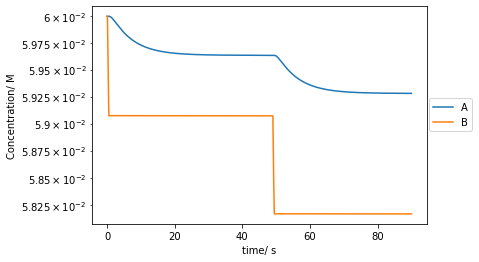

In [ ]:
plt.plot(t[::10000],As[::10000],label='A')
plt.plot(t[::10000],Bs[::10000],label='B')
plt.yscale('log')
plt.xlabel('time/ s')
plt.ylabel('Concentration/ M')
plt.legend(bbox_to_anchor =(1.15, 0.6))
plt.show()

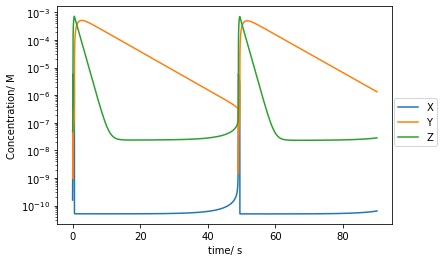

In [ ]:
plt.plot(t[::10000],Xs[::10000],label='X')
plt.plot(t[::10000],Ys[::10000],label='Y')
plt.plot(t[::10000],Zs[::10000],label='Z')
plt.yscale('log')
plt.xlabel('time/ s')
plt.ylabel('Concentration/ M')
plt.legend(bbox_to_anchor =(1.15, 0.6))
plt.show()

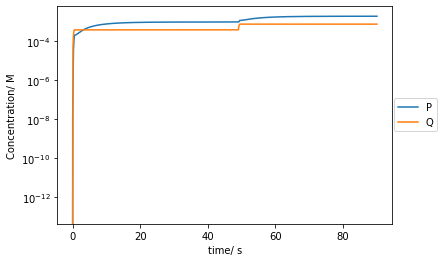

In [ ]:
plt.plot(t[::10000],Ps[::10000],label='P')
plt.plot(t[::10000],Qs[::10000],label='Q')
plt.yscale('log')
plt.xlabel('time/ s')
plt.ylabel('Concentration/ M')
plt.legend(bbox_to_anchor =(1.15, 0.6))
plt.show()

In [ ]:
A, B, X, Y, Z, P, Q = 0.06, 0.06, 10**(-9.8),10**(-6.52), 10**(-7.32), 0, 0
concs = [A, B, X, Y, Z, P, Q]
t, conc_t= t, conc_t= oreg_calc(concs, method = 'RK4', dt = 3e-6)
As, Bs, Xs, Ys, Zs, Ps, Qs = conc_t

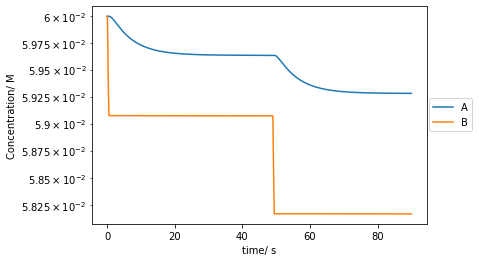

In [ ]:
plt.plot(t[::10000],As[::10000],label='A')
plt.plot(t[::10000],Bs[::10000],label='B')
plt.yscale('log')
plt.xlabel('time/ s')
plt.ylabel('Concentration/ M')
plt.legend(bbox_to_anchor =(1.15, 0.6))
plt.show()

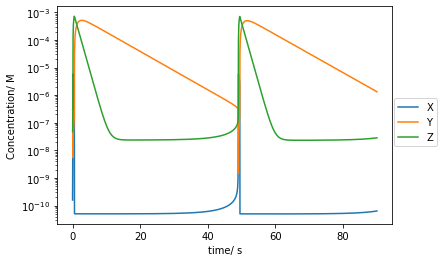

In [ ]:
plt.plot(t[::10000],Xs[::10000],label='X')
plt.plot(t[::10000],Ys[::10000],label='Y')
plt.plot(t[::10000],Zs[::10000],label='Z')
plt.yscale('log')
plt.xlabel('time/ s')
plt.ylabel('Concentration/ M')
plt.legend(bbox_to_anchor =(1.15, 0.6))
plt.show()

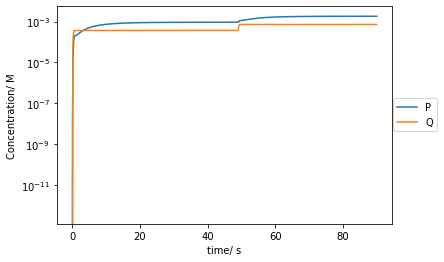

In [ ]:
plt.plot(t[::10000],Ps[::10000],label='P')
plt.plot(t[::10000],Qs[::10000],label='Q')
plt.yscale('log')
plt.xlabel('time/ s')
plt.ylabel('Concentration/ M')
plt.legend(bbox_to_anchor =(1.15, 0.6))
plt.show()

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()